In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

import datetime

from arch import arch_model
import wrds

import numpy.linalg as la
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt

from collections import defaultdict

from joblib import Parallel, delayed

from tqdm import tqdm
import seaborn as sns

In [14]:
df = pd.read_csv("final_dataset_backtest.csv")
df

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,...,ou_forecast_20d,z_score_20d,fed_funds_rate,actual_vol_1d_lag1,actual_vol_5d,actual_vol_5d_lag1,actual_vol_10d,actual_vol_10d_lag1,actual_vol_20d,actual_vol_20d_lag1
0,1986-04-01,10008,GACO,-18.50,0.042254,2945.0,1.0,47.95,-0.011717,-0.011773,...,NaN,0.000000,7.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-04-02,10008,GACO,-18.00,-0.027027,2945.0,1.0,231.00,0.001289,0.001186,...,-0.002341,-0.753421,7.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986-04-03,10008,GACO,-18.25,0.013889,2945.0,1.0,3.50,-0.009560,-0.009571,...,-0.002341,0.365600,7.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986-04-04,10008,GACO,-18.25,0.000000,2945.0,1.0,39.50,-0.013887,-0.014239,...,-0.002341,-0.261429,6.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986-04-07,10008,GACO,-18.25,0.000000,2945.0,1.0,68.00,-0.002678,-0.002752,...,-0.002341,-0.143432,7.09,NaN,0.056338,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14686405,2024-12-24,93436,TSLA,462.28,0.073572,3210060.0,1.0,593515.06,0.010566,0.010521,...,0.001722,-0.114998,4.33,NaN,0.131718,0.106439,0.157805,0.145334,0.170305,0.167895
14686406,2024-12-26,93436,TSLA,454.13,-0.017630,3210060.0,1.0,763922.73,0.000346,0.000282,...,0.001722,-0.317544,4.33,NaN,0.095352,0.131718,0.152724,0.157805,0.172878,0.170305
14686407,2024-12-27,93436,TSLA,431.66,-0.049479,3210060.0,1.0,823703.45,-0.010692,-0.010775,...,0.001722,0.117134,4.33,NaN,0.111126,0.095352,0.161946,0.152724,0.182332,0.172878
14686408,2024-12-30,93436,TSLA,417.41,-0.033012,3210060.0,1.0,647054.52,-0.009878,-0.009900,...,0.001722,0.186010,4.33,NaN,0.110521,0.111126,0.159511,0.161946,0.186401,0.182332


In [56]:
df['realized_return_5'] = (
        df.groupby('permno')['retx']
        .transform(lambda x: x.shift(-1).rolling(5).sum())
    )

In [70]:
df[df['ticker'] == 'TSLA'][['date', 'retx_relative_lag1', 'ou_forecast_1d', 'ticker', 
                            'ou_forecast_5d', 'realized_return_5', 'ou_forecast_20d', 
                            'retx']].sort_values('date')

,date,retx_relative_lag1,ou_forecast_1d,ticker,ou_forecast_5d,realized_return_5,ou_forecast_20d,retx
14682886,2010-10-01,NaN,NaN,TSLA,NaN,NaN,NaN,0.009556
14682887,2010-10-04,0.003401,0.002332,TSLA,0.001732,NaN,0.001722,0.018932
14682888,2010-10-05,0.029868,0.011949,TSLA,0.001900,NaN,0.001722,0.006193
14682889,2010-10-06,-0.017231,-0.005165,TSLA,0.001602,NaN,0.001722,-0.031250
14682890,2010-10-07,-0.022794,-0.007186,TSLA,0.001566,-0.007591,0.001722,-0.001466
...,...,...,...,...,...,...,...,...
14686405,2024-12-24,0.024495,0.009996,TSLA,0.001866,0.034959,0.001722,0.073572
14686406,2024-12-26,0.063943,0.024329,TSLA,0.002116,-0.005523,0.001722,-0.017630
14686407,2024-12-27,-0.021683,-0.006782,TSLA,0.001574,-0.003892,0.001722,-0.049479
14686408,2024-12-30,-0.035035,-0.011634,TSLA,0.001489,-0.059059,0.001722,-0.033012


In [58]:
subset = df[df['ticker'] == 'TSLA'][['ou_forecast_1d', 'retx', 'ou_forecast_5d', 'realized_return_5', 'ou_forecast_20d']].dropna()

# Compute correlation matrix
correlation_matrix = subset.corr()

print(correlation_matrix)

                   ou_forecast_1d      retx  ou_forecast_5d  \
ou_forecast_1d           1.000000 -0.020057        1.000000   
retx                    -0.020057  1.000000       -0.020057   
ou_forecast_5d           1.000000 -0.020057        1.000000   
realized_return_5        0.396231  0.449023        0.396231   
ou_forecast_20d          1.000000 -0.020057        1.000000   

                   realized_return_5  ou_forecast_20d  
ou_forecast_1d              0.396231         1.000000  
retx                        0.449023        -0.020057  
ou_forecast_5d              0.396231         1.000000  
realized_return_5           1.000000         0.396231  
ou_forecast_20d             0.396231         1.000000  


In [15]:
df.isnull().sum()

date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
adv20                                 0
adj_prc                               0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12441
group_std_retx_relative_1d     14686410
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d            0
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0


In [67]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_forecasts_vs_actual(df, ticker, days, start_date=None):
    """
    Plots GARCH vs Actual Volatility and OU Forecast vs Actual Returns for a given ticker and forecast horizon.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the relevant columns.
    ticker : str
        Ticker symbol to filter the data.
    days : int
        Forecast horizon (e.g., 1, 5, 10, 20).
    start_date : str or pd.Timestamp, optional
        Start date for the plot (format: 'YYYY-MM-DD'). Plots from this date onwards.
    """
    df['date'] = pd.to_datetime(df['date'])
    valid_days = [1, 5, 10, 20]
    if days not in valid_days:
        raise ValueError(f"Invalid 'days' value. Choose from {valid_days}.")

    stock_df = df[df['ticker'] == ticker].sort_values('date').copy()
    if stock_df.empty:
        print(f"No data found for ticker: {ticker}")
        return

    # Apply start date filter if provided
    if start_date:
        stock_df = stock_df[stock_df['date'] >= pd.to_datetime(start_date)]
        if stock_df.empty:
            print(f"No data available for {ticker} after {start_date}.")
            return

    # Build dynamic column names
    garch_col = f"garch_vol_{days}d_lag1"
    ou_col = f"ou_forecast_{days}d"
    
    if days == 1:
        actual_vol_col = vol
    else:
        actual_vol_col = f"actual_vol_{days}d"

    # Compute realized returns over the horizon for proper OU comparison
    stock_df['realized_return'] = (
        stock_df.groupby('permno')['retx']
        .transform(lambda x: x.shift(-1).rolling(days).sum())
    )

    plot_df = stock_df[['date', garch_col, ou_col, actual_vol_col, 'realized_return']].dropna()

    if plot_df.empty:
        print(f"No valid data to plot for ticker '{ticker}' and horizon {days}d.")
        return

    # Plot 1: GARCH vs Actual Volatility
    plt.figure(figsize=(12, 5))
    plt.plot(plot_df['date'], plot_df[garch_col], label=f'GARCH Volatility ({days}d)', linestyle='--', color='red', alpha=0.5)
    plt.plot(plot_df['date'], plot_df[actual_vol_col], label=f'Actual Volatility ({days}d)', linestyle='-', color='green', alpha=0.5)
    plt.title(f'GARCH vs Actual Volatility ({days}d) - {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot 2: OU Forecast vs Realized Return
    plt.figure(figsize=(12, 5))
    plt.plot(plot_df['date'], plot_df[ou_col], label=f'OU Forecasted Return ({days}d)', linestyle='--', color='tab:green', alpha=0.8)
    plt.plot(plot_df['date'], plot_df['realized_return'], label=f'Realized Return ({days}d)', linestyle='-', color='tab:red', alpha=0.7)
    plt.title(f'OU Forecast vs Realized Return ({days}d) - {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

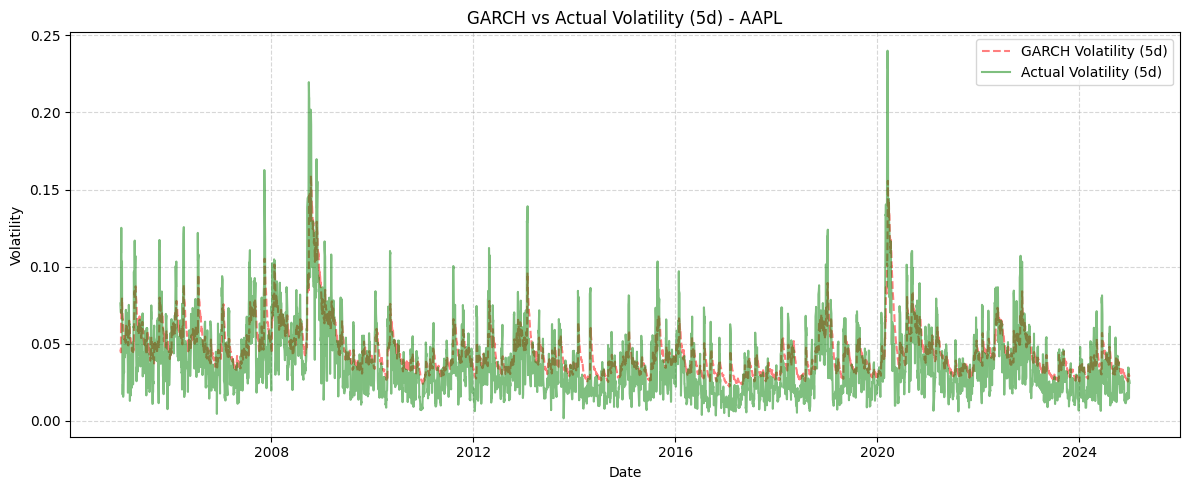

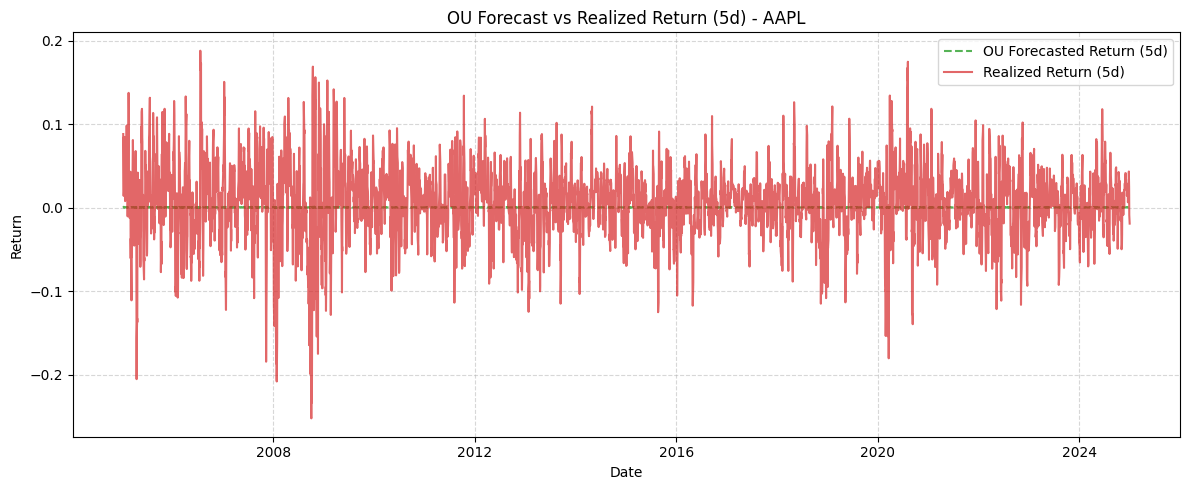

In [68]:
plot_forecasts_vs_actual(df, ticker='AAPL', days=5, start_date='2005-01-01')

In [26]:
df['group_std_retx_relative_1d'] = (
    df.groupby(['date', 'group_id'])['retx_relative']
      .transform('std')
)
df['adj_prc'] = df['prc'] / df['cfacpr']

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

df.isnull().sum()

date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
adv20                                 0
adj_prc                               0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12441
group_std_retx_relative_1d            0
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d            0
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0


In [5]:
def add_actual_volatility(df):
    """
    Adds realized (historical) volatility over multiple time horizons: 1, 5, 10, and 20 days.
    """
    horizons = [1, 5, 10, 20]
    df = df.sort_values(['permno', 'date']).copy()

    for horizon in horizons:
        vol_col = f'actual_vol_{horizon}d'
        vol_lag_col = f'{vol_col}_lag1'

        # For 1-day volatility, std is always NaN (you need at least 2 points). Set it to 0 explicitly or skip.
        if horizon == 1:
            df[vol_col] = np.nan  # Volatility over 1 day doesn't make sense statistically.
        else:
            min_p = max(2, horizon // 2)
            df[vol_col] = (
                df.groupby('permno')['retx']
                  .rolling(window=horizon, min_periods=min_p)
                  .std()
                  .reset_index(level=0, drop=True)
            )

        df[vol_lag_col] = df.groupby('permno')[vol_col].shift(1)

    return df

df = add_actual_volatility(df)
df.isnull().sum()

date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12448
group_std_retx_relative_1d            0
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d            0
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0
z_score_classic_10d_lag1              0
group_std_retx_relative_20d           0


In [6]:
def compute_group_std_correct(df, horizon):
    return (
        df.groupby(['group_id'])
          .apply(lambda group: group.sort_values('date')
                                  .assign(**{f'group_std_retx_relative_{horizon}d': 
                                              group['retx_relative'].shift(1).rolling(window=horizon, min_periods=1).std()}))
          .reset_index(drop=True)
    )


# Now you can call:
df = compute_group_std_correct(df, horizon=5)
df.isnull().sum()

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_14704/2550445080.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sort_values('date')


date                                  0
permno                                0
ticker                             1346
prc                                   0
retx                                  0
shrout                                0
cfacpr                                0
vol                                   0
vwretd                                0
vwretx                                0
trading_start                         0
group_id                              0
group_avg_retx                        0
retx_relative                         0
retx_relative_lag1                12448
group_std_retx_relative_1d            0
z_score_classic_1d                    0
z_score_classic_1d_lag1               0
group_std_retx_relative_5d         2896
z_score_classic_5d                    0
z_score_classic_5d_lag1               0
group_std_retx_relative_10d           0
z_score_classic_10d                   0
z_score_classic_10d_lag1              0
group_std_retx_relative_20d           0


In [7]:
correlation_matrix = df[['retx', 'garch_vol_5d_lag1', 'ou_forecast_5d', 'z_score_5d', 
                         'actual_vol_5d', 'retx_relative_lag1', 'group_std_retx_relative_5d', 'adj_prc']].corr()
print(correlation_matrix)


                                retx  garch_vol_5d_lag1  ou_forecast_5d  \
retx                        1.000000           0.013014        0.030155   
garch_vol_5d_lag1           0.013014           1.000000        0.096858   
ou_forecast_5d              0.030155           0.096858        1.000000   
z_score_5d                  0.041097          -0.006065       -0.131908   
actual_vol_5d               0.110834           0.726949        0.074802   
retx_relative_lag1         -0.076235           0.020099        0.188360   
group_std_retx_relative_5d  0.014954           0.732280        0.067952   
adj_prc                     0.000999           0.016994       -0.006501   

                            z_score_5d  actual_vol_5d  retx_relative_lag1  \
retx                          0.041097       0.110834           -0.076235   
garch_vol_5d_lag1            -0.006065       0.726949            0.020099   
ou_forecast_5d               -0.131908       0.074802            0.188360   
z_score_5d      

In [8]:
horizons = [1, 5, 10, 20]

for h in horizons:
    df[f'future_return_{h}d'] = (
        df.groupby('permno')['retx']
          .transform(lambda x: x.shift(-h).rolling(h).sum())
    )
def evaluate_signal(df, horizon):
    z_col = f'z_score_{horizon}d'
    future_return_col = f'future_return_{horizon}d'
    
    # Drop missing data for evaluation
    valid_data = df[[z_col, future_return_col]].dropna()
    
    # Directional Accuracy (Are signals pointing the right way?)
    correct_direction = np.sign(valid_data[z_col]) == np.sign(valid_data[future_return_col])
    accuracy = correct_direction.mean()
    
    # Correlation
    corr = valid_data[z_col].corr(valid_data[future_return_col])
    
    # Return average future returns for high z-scores
    high_signal = valid_data[np.abs(valid_data[z_col]) >= 1.5]  # Strong signals
    avg_return_high_signal = high_signal[future_return_col].mean()
    
    return accuracy, corr, avg_return_high_signal

# Run Evaluation for All Horizons
for h in horizons:
    acc, corr, avg_ret = evaluate_signal(df, h)
    print(f"\n📈 Horizon: {h} Days")
    print(f"✔️ Direction Accuracy: {acc:.2%}")
    print(f"🔗 Correlation: {corr:.4f}")
    print(f"💰 Avg. Future Return (|Z| ≥ 1.5): {avg_ret:.4f}")


📈 Horizon: 1 Days
✔️ Direction Accuracy: 43.85%
🔗 Correlation: 0.0102
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0013

📈 Horizon: 5 Days
✔️ Direction Accuracy: 49.75%
🔗 Correlation: 0.0173
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0031

📈 Horizon: 10 Days
✔️ Direction Accuracy: 50.29%
🔗 Correlation: 0.0177
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0064

📈 Horizon: 20 Days
✔️ Direction Accuracy: 50.54%
🔗 Correlation: 0.0155
💰 Avg. Future Return (|Z| ≥ 1.5): 0.0136


In [9]:
def plot_vol_and_return_analysis(df, ticker, horizon=5, start_year=None):
    df_ticker = df[df['ticker'] == ticker].sort_values('date')
    if start_year:
        df_ticker = df_ticker[df_ticker['date'].dt.year >= start_year]

    if df_ticker.empty:
        print(f"No data found for ticker '{ticker}' after filtering.")
        return
    
    plt.figure(figsize=(14, 6))

    # Plot Actual vs Predicted Volatility
    plt.subplot(1, 2, 1)
    plt.plot(df_ticker['date'], df_ticker[f'actual_vol_{horizon}d_lag1'], label='Actual Volatility')
    plt.plot(df_ticker['date'], df_ticker[f'garch_vol_{horizon}d_lag1'], label='GARCH Predicted')
    plt.title(f'{ticker} - Volatility ({horizon}D Horizon)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)

    # Plot Z-Score vs. Future Returns
    plt.subplot(1, 2, 2)
    plt.scatter(df_ticker[f'z_score_{horizon}d'], df_ticker[f'future_return_{horizon}d'], alpha=0.3)
    plt.axhline(0, color='black', linestyle='--')
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f'{ticker} - Z-Score vs Future Return ({horizon}D)')
    plt.xlabel('Z-Score')
    plt.ylabel('Future Return')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


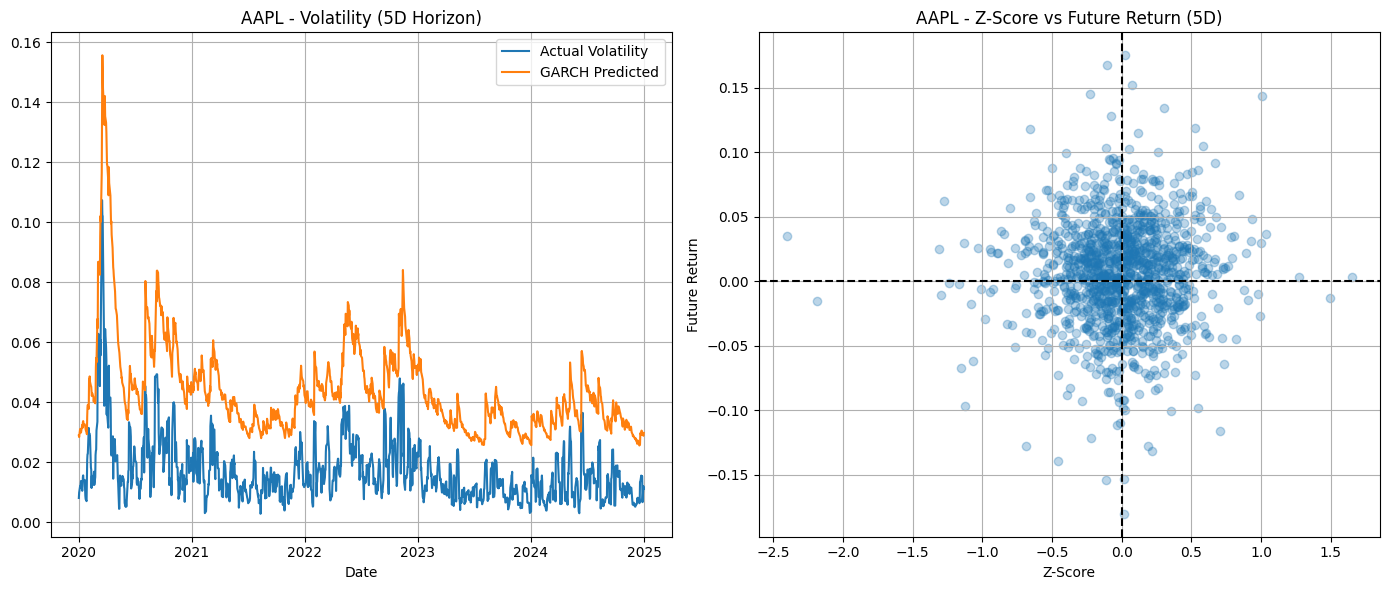

In [10]:
plot_vol_and_return_analysis(df, ticker='AAPL', horizon=5, start_year=2020)


In [11]:
def analyze_ou_forecast(df, horizon=5):
    ou_col = f'ou_forecast_{horizon}d'
    actual_col = f'retx_relative_lag1'

    if ou_col not in df.columns or actual_col not in df.columns:
        raise ValueError(f"Required columns {ou_col} or {actual_col} are missing.")

    # Filter and drop NaNs
    data = df[[ou_col, actual_col]].dropna()

    # Correlation
    correlation = data[ou_col].corr(data[actual_col])
    print(f"📈 Correlation between OU Forecast and Actual Return: {correlation:.4f}")

    # Plot: Scatter Plot with Regression Line
    plt.figure(figsize=(8, 5))
    sns.regplot(x=ou_col, y=actual_col, data=data, line_kws={"color": "red"})
    plt.title(f'OU Forecast vs Actual Return (Horizon: {horizon} Days)')
    plt.xlabel('OU Forecast')
    plt.ylabel('Actual Return')
    plt.grid(True)
    plt.show()

    # Analyze Quantiles of OU Forecast
    data['ou_quantile'] = pd.qcut(data[ou_col], q=5)
    quantile_means = data.groupby('ou_quantile')[actual_col].mean()

    print("\n📊 Average Actual Return by OU Forecast Quantiles:")
    print(quantile_means)

    # Plot: Quantile Analysis
    quantile_means.plot(kind='bar', figsize=(8, 4), title='Average Actual Return by OU Forecast Quantiles')
    plt.ylabel('Average Actual Return')
    plt.grid(True)
    plt.show()

📈 Correlation between OU Forecast and Actual Return: 0.1884


/Users/komalniraula/myenv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/komalniraula/myenv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/komalniraula/myenv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


KeyboardInterrupt: 

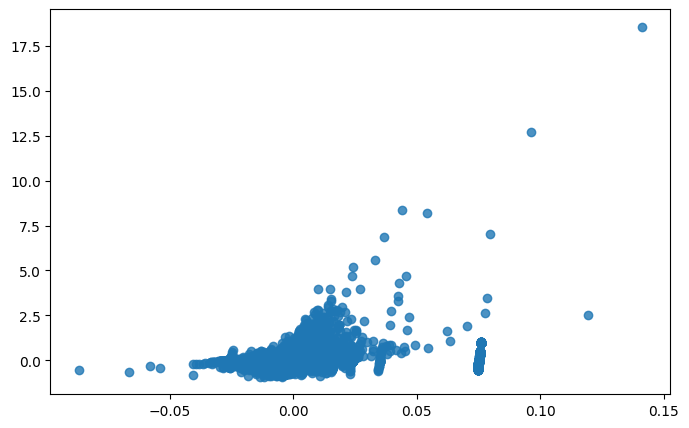

In [12]:
analyze_ou_forecast(df, horizon=5)
analyze_ou_forecast(df, horizon=10)